[HR Analytics:](https://datahack.analyticsvidhya.com/contest/wns-analytics-hackathon-2018-1/#ProblemStatement) Identify the employees most likely to get promoted.

# Setup

In [1]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "hr_analytics"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the data

## Download the data

In [102]:
DATASETS_PATH = os.path.join("datasets", "hr")

def create_dir(file_path):
    if not os.path.isdir(file_path):
        os.makedirs(file_path)

In [104]:
create_dir(DATASETS_PATH)

* Download `test.csv`, `train.csv`, and `sample.csv` to `HR_PATH` folder

In [4]:
def load_data(path, file_name):
    csv_path = os.path.join(path, file_name)
    return pd.read_csv(csv_path)

## Take a quick look at the data structure

In [5]:
train = load_data(HR_PATH, 'train.csv')
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


* Drop `employee_id`

In [6]:
train_copy = train.copy()
train_copy = train_copy.drop(['employee_id'], axis=1)

In [7]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  object 
 1   region                54808 non-null  object 
 2   education             52399 non-null  object 
 3   gender                54808 non-null  object 
 4   recruitment_channel   54808 non-null  object 
 5   no_of_trainings       54808 non-null  int64  
 6   age                   54808 non-null  int64  
 7   previous_year_rating  50684 non-null  float64
 8   length_of_service     54808 non-null  int64  
 9   KPIs_met >80%         54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


* Categorical and numeric variables
* Missing values for `education` and `previous_year_rating`

In [8]:
train_copy[train_copy.isnull().any(axis=1)]

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
10,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
21,Operations,region_15,NaN,m,sourcing,1,41,4.0,11,0,0,57,0
23,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,0,70,0
29,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,0,44,0
32,Sales & Marketing,region_7,NaN,f,sourcing,1,24,1.0,2,0,0,48,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54742,Sales & Marketing,region_31,NaN,m,other,1,28,4.0,3,0,0,47,0
54746,Finance,region_6,Bachelor's,m,other,1,28,NaN,1,1,0,61,0
54773,Finance,region_2,Bachelor's,m,other,1,23,NaN,1,1,0,61,0
54801,Technology,region_26,Bachelor's,f,sourcing,1,31,NaN,1,0,0,78,0


* `previous_year_rating` missing when `length_of_service` is 1; can imputate with 0
* `education` just missing and can replace with constant e.g. missing

In [9]:
def check_cardinality(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f'{col}: {df[col].nunique()}')

In [10]:
check_cardinality(train_copy)

department: 9
region: 34
education: 3
gender: 2
recruitment_channel: 3


* 5 categories
* Cardinality too high for `region` and will elect to remove

In [11]:
train_copy.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


Saving figure attribute_histgram_plots


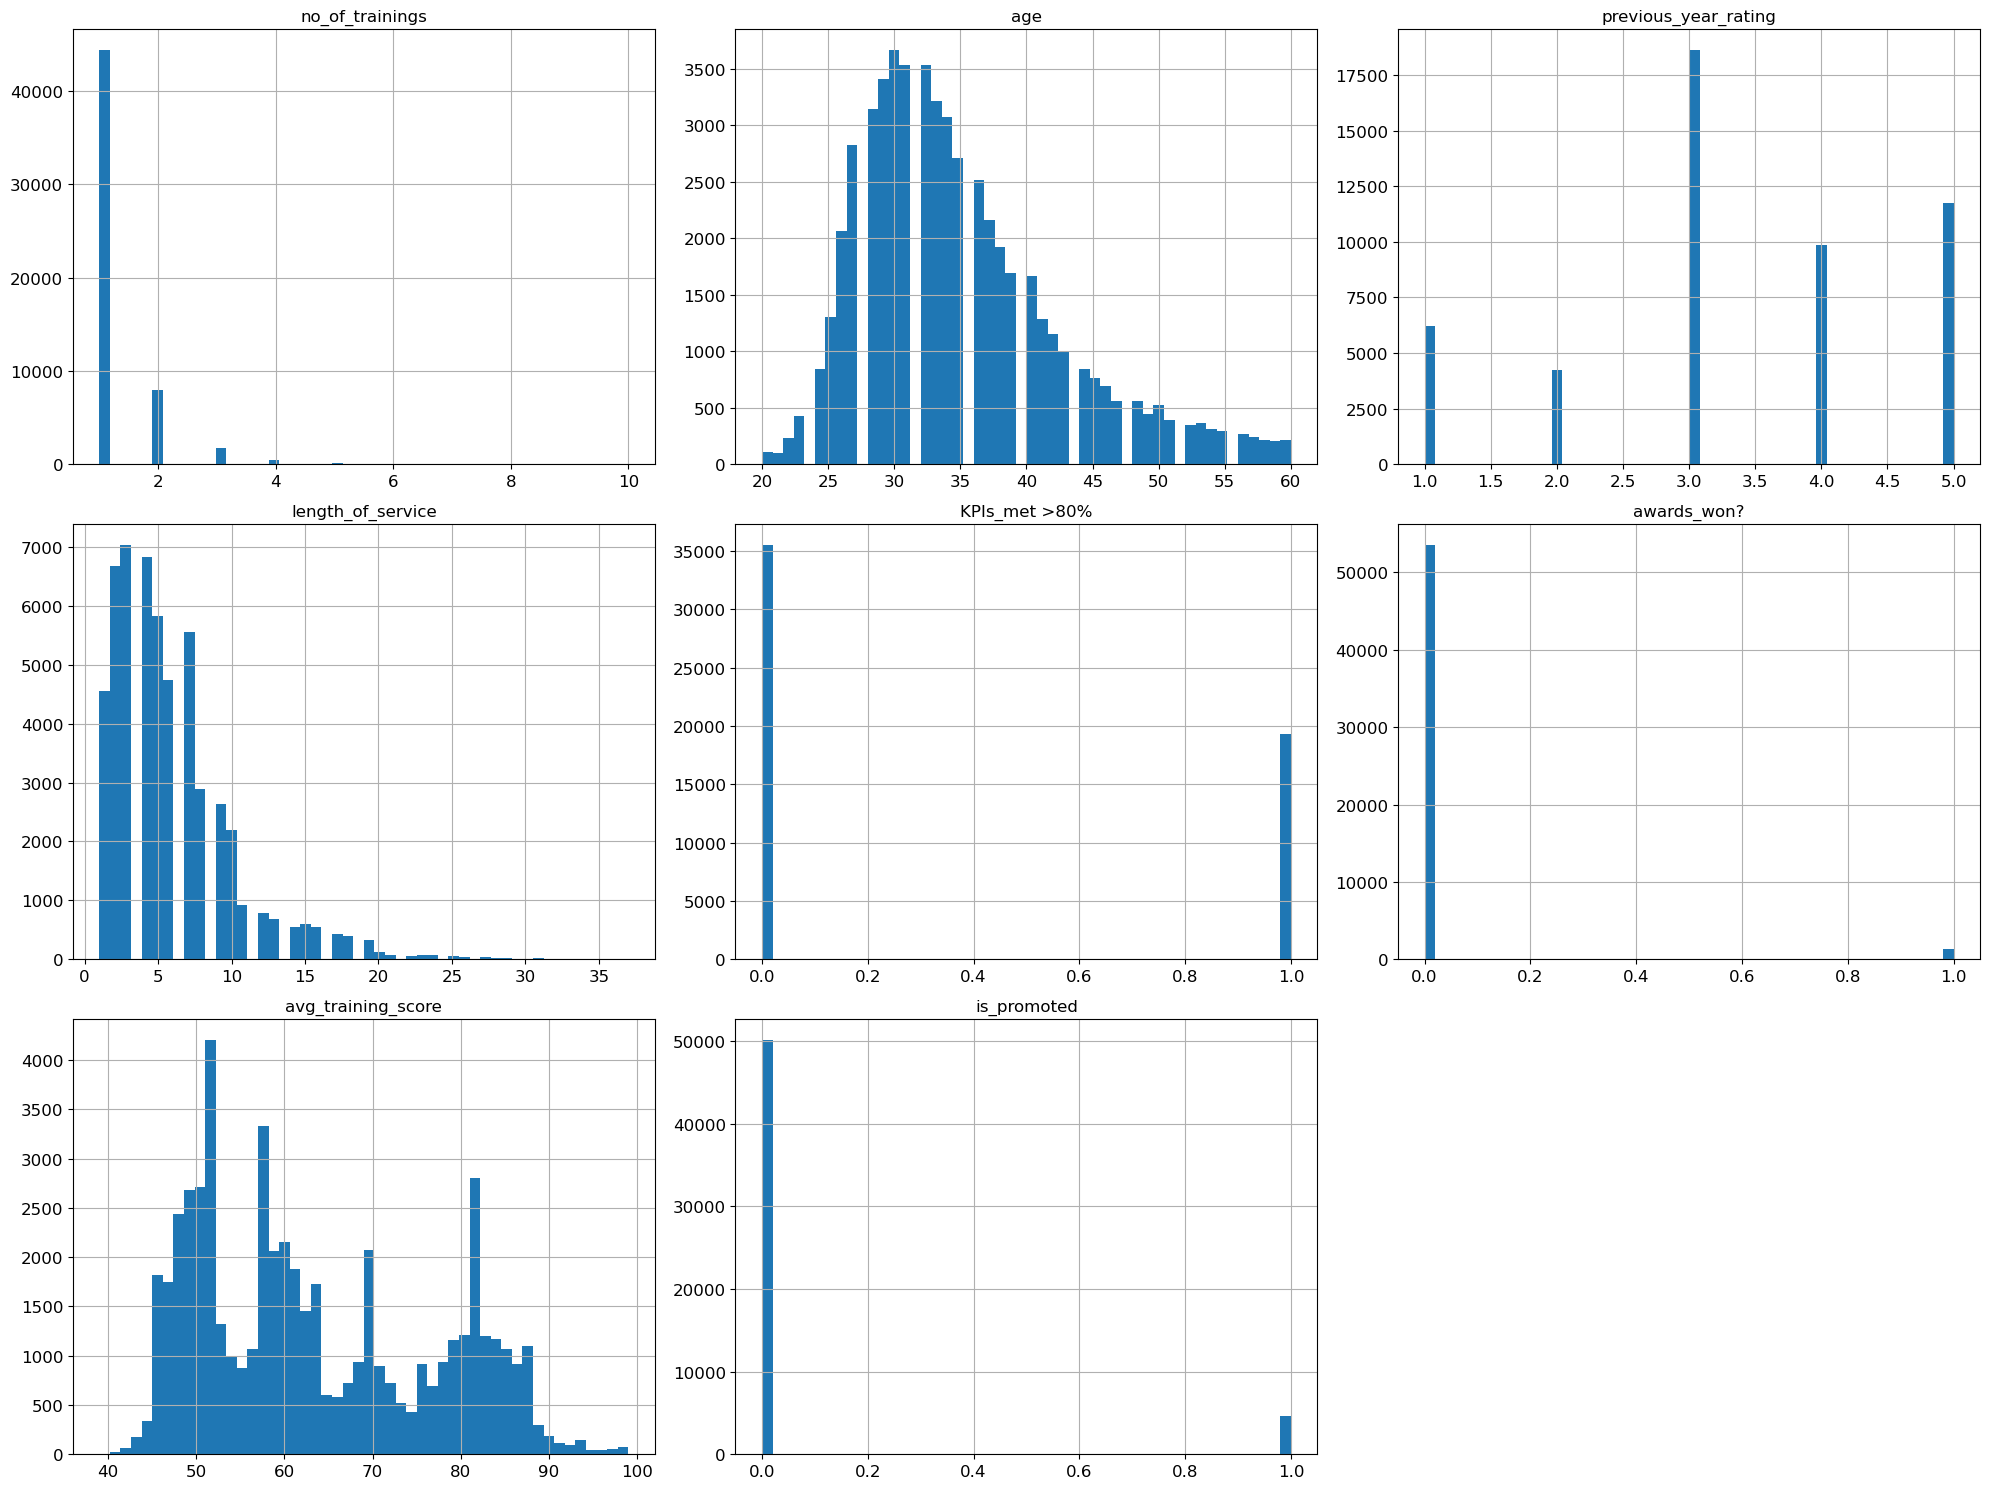

In [12]:
train_copy.hist(bins=50, figsize=(20,15))
save_fig("attribute_histgram_plots")

* `no_of_trainings` discrete
* `age` right skewed
* `previous_year_rating` discrete 1-5
* `length_of_service` right skewed
* `KPIs_met` boolean
* `awards_won?` boolean, few examples of 1
* `avg_training_score` could benefit from binning
* `is_promoted` target, significant class imbalance

In [13]:
print('is_promoted:')
print(train_copy['is_promoted'].value_counts())
print(train_copy['is_promoted'].value_counts()/len(train_copy))

is_promoted:
0    50140
1     4668
Name: is_promoted, dtype: int64
0    0.91483
1    0.08517
Name: is_promoted, dtype: float64


In [14]:
print('awards_won?:')
print(train_copy['awards_won?'].value_counts())
print(train_copy['awards_won?'].value_counts()/len(train_copy))

awards_won?:
0    53538
1     1270
Name: awards_won?, dtype: int64
0    0.976828
1    0.023172
Name: awards_won?, dtype: float64


# Create a test set

* Test set has already been created, so not applicable here

# EDA

## Looking for correlations

In [15]:
corr_matrix = train_copy.corr()

In [16]:
corr_matrix["is_promoted"].sort_values(ascending=False)

is_promoted             1.000000
KPIs_met >80%           0.221582
awards_won?             0.195871
avg_training_score      0.181147
previous_year_rating    0.159320
length_of_service      -0.010670
age                    -0.017166
no_of_trainings        -0.024896
Name: is_promoted, dtype: float64

* `KPIs_met >80%` biggest predictor of target

# Prepare the data for machine learning algorithms 

In [17]:
hr = train.drop("is_promoted", axis=1)  # drop labels for training set
hr_labels = train["is_promoted"].copy()

## Transformation pipelines

* Build a pipeline for preprocessing the numerical attributes:

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('num_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('std_scaler', StandardScaler()),
])

In [19]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot', OneHotEncoder()),
])

In [20]:
from sklearn.compose import ColumnTransformer

num_attribs = [cname for cname in hr.columns if hr[cname].dtype in ['int64', 'float64']]
cat_attribs = [cname for cname in hr.columns if hr[cname].dtype == "object"]

num_attribs.remove('employee_id')
cat_attribs.remove('region')

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

hr_prepared = full_pipeline.fit_transform(hr)

In [21]:
hr_prepared

array([[-0.41527615,  0.02559817,  1.28387791, ...,  0.        ,
         0.        ,  1.        ],
       [-0.41527615, -0.62713488,  1.28387791, ...,  1.        ,
         0.        ,  0.        ],
       [-0.41527615, -0.10494844, -0.05262314, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.41527615, -1.01877471,  1.28387791, ...,  1.        ,
         0.        ,  0.        ],
       [-0.41527615, -0.75768149, -1.3891242 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.41527615, -1.01877471, -1.3891242 , ...,  1.        ,
         0.        ,  0.        ]])

In [22]:
hr_prepared.shape

(54808, 25)

# Select and train a model 

## Fit models

In [70]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(hr_prepared, hr_labels)

SGDClassifier(random_state=42)

In [71]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(hr_prepared, hr_labels)

RandomForestClassifier(random_state=42)

In [77]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(hr_prepared, hr_labels)

KNeighborsClassifier()

## Cross-validation

In [72]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

sgd_scores = cross_val_predict(sgd_clf, hr_prepared, hr_labels, cv=3, method="decision_function")
sgd_precisions, sgd_recalls, sgd_thresholds = precision_recall_curve(hr_labels, sgd_scores)

In [73]:
forest_fcst = cross_val_predict(forest_clf, hr_prepared, hr_labels, cv=3, method="predict_proba")
forest_scores = forest_fcst[:, 1]
forest_precisions, forest_recalls, forest_thresholds = precision_recall_curve(hr_labels, forest_scores)

In [78]:
knn_fcst = cross_val_predict(knn_clf, hr_prepared, hr_labels, cv=3, method="predict_proba")
knn_scores = knn_fcst[:, 1]
knn_precisions, knn_recalls, knn_thresholds = precision_recall_curve(hr_labels, knn_scores)

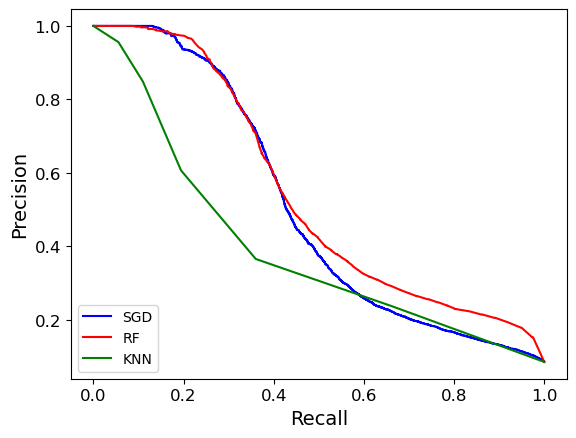

In [79]:
plt.plot(sgd_recalls, sgd_precisions, "b", label="SGD")
plt.plot(forest_recalls, forest_precisions, "r", label="RF")
plt.plot(knn_recalls, knn_precisions, "g", label="KNN")
plt.legend(loc="lower left")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [80]:
sgd_auc = auc(sgd_recalls, sgd_precisions)
forest_auc = auc(forest_recalls, forest_precisions)
knn_auc = auc(knn_recalls, knn_precisions)
print('SGD AUC:', sgd_auc)
print(' RF AUC:', forest_auc)
print('KNN AUC:', knn_auc)

SGD AUC: 0.5061986916964105
 RF AUC: 0.5416596391497872
KNN AUC: 0.3908269899251636


* Strange behavior of precision recall curves but I think I did everything correctly
* Room for improvement for all classifiers
* RF outperforms others

# Fine-tune your model

In [82]:
hr_prepared.shape

(54808, 25)

## Randomized search

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),  # will use max of homl (8) and sqrt of feature space (6)
    }

forest_clf = RandomForestClassifier(random_state=42)  # re-fit without defining n_estimators
rnd_search = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='f1', random_state=42)
rnd_search.fit(hr_prepared, hr_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020B6BC19D90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020B6BC19550>},
                   random_state=42, scoring='f1')

In [85]:
cvres = rnd_search.cv_results_

In [ ]:
print(cvres.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [91]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.4825707492465602 {'max_features': 7, 'n_estimators': 180}
0.4641546009747617 {'max_features': 5, 'n_estimators': 15}
0.44501031671317676 {'max_features': 3, 'n_estimators': 72}
0.464366305617302 {'max_features': 5, 'n_estimators': 21}
0.4809223304012543 {'max_features': 7, 'n_estimators': 122}
0.44628619755603616 {'max_features': 3, 'n_estimators': 75}
0.44505395597958686 {'max_features': 3, 'n_estimators': 88}
0.473386780437295 {'max_features': 5, 'n_estimators': 100}
0.4467835613655778 {'max_features': 3, 'n_estimators': 150}
0.3267651314875811 {'max_features': 5, 'n_estimators': 2}


* Best performance with `max_features` = 7 and `n_estimators` = 180
* Both at top end of param range
* Opportunity to further optimize by shifting/ increasing param range

## Analyze the best models and their errors

In [92]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.02866556, 0.17220043, 0.05816031, 0.11846432, 0.04773148,
       0.02935235, 0.35408284, 0.01214352, 0.00805769, 0.00492871,
       0.00302723, 0.02068865, 0.01267839, 0.00640283, 0.03318653,
       0.00833693, 0.01013325, 0.001477  , 0.00890049, 0.0030011 ,
       0.01203262, 0.0121904 , 0.01457096, 0.0048272 , 0.01475922])

In [93]:
cat_encoder = full_pipeline.named_transformers_["cat"]["one_hot"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3540828406578188, 'avg_training_score'),
 (0.17220042702319255, 'age'),
 (0.11846431862203552, 'length_of_service'),
 (0.05816030695093077, 'previous_year_rating'),
 (0.0477314788489947, 'KPIs_met >80%'),
 (0.03318653076004579, 'Sales & Marketing'),
 (0.029352348539061074, 'awards_won?'),
 (0.028665556900288738, 'no_of_trainings'),
 (0.020688654520335855, 'Operations'),
 (0.012678389374444892, 'Procurement'),
 (0.012143522072382531, 'Analytics'),
 (0.008336928864093962, 'Technology'),
 (0.0080576930509313, 'Finance'),
 (0.006402829692442359, 'R&D'),
 (0.0049287055028550235, 'HR'),
 (0.00302722725694184, 'Legal')]

# Evaluate system on test set

## Generate predictions

In [94]:
final_model = rnd_search.best_estimator_

X_test = load_data(HR_PATH, 'test.csv')
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

 ## Create prediction file

In [105]:
employee_id = X_test['employee_id']

submission_df_1 = pd.DataFrame({
    "employee_id": employee_id,
    "is_promoted": final_predictions
})

In [108]:
SUBMISSIONS_PATH = os.path.join('submissions', 'hr')
create_dir(SUBMISSIONS_PATH)

In [123]:
def save_submission(model, path, file_name, index=False):
    csv_path = os.path.join(path, file_name)
    return model.to_csv(csv_path, index=index)

In [124]:
save_submission(submission_df_1, SUBMISSIONS_PATH, 'submission_1.csv')

## Save model

In [116]:
MODELS_PATH = os.path.join('models', 'hr')
create_dir(MODELS_PATH)

In [119]:
def save_model(path, model_name, model):
    model_path = os.path.join(path, model_name)
    joblib.dump(model, model_path)

In [120]:
import joblib

save_model(MODELS_PATH, 'final_hr_model.pkl', final_model)